# Task-1 Image Bases Learning

### Import Packages

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D,MaxPooling1D, Flatten,Conv1D
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn.utils import class_weight

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import scipy as sp
import PIL

from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


### Reading the file names

In [0]:
# Dataset
train_data_dir = 'LunarLanderFramesPart1/'

# Set up some parmaeters for data loading
sample_rate = 0.1

# Desired dimensions of our images.
img_width, img_height = 150, 150

# Different backends (e.g. tensorflow and theano) use different orderings for image data - fix this!
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

    
# Different moves of lunar ship are stored in dictionary
moves={'0':'none',
       '1':'up',
       '2':'left',
       '3':'right'}
    

image_filenames = [train_data_dir+i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate)) #randomly sample the data


### Colour image and imbalanced data 

Images used for training are coloured images and imbalnce class is not handelled 

Reading images in array

In [3]:
count = len(image_filenames)

# Initialise arrays for data storage
X_data = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.str)


# Iterate through the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):

    # Load the images and resize them
    image = cv2.imread(image_file, cv2.IMREAD_COLOR)
    image = cv2.resize(image,(img_height, img_width), interpolation=cv2.INTER_CUBIC)
    image = image[:,:,[2,1,0]] # OpenCV and matplotlib use different channel orderings so fix this

    # If channel order of network does not match open cv format swap it
    if K.image_data_format() == 'channels_first':
        image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)

    # Add image data to data array and normalise
    X_data[i] = image
    X_data[i] = X_data[i]/255

    # Add label to label array
    lb = moves[image_file[-6]]
        
    y_data = np.append(y_data, lb)

    if i%1000 == 0: print('Processed {} images'.format(i))


Processed 0 images
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images


Split data into train and test

In [0]:
# Perfrom split to train, validate and test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

In [0]:
task_accuracy_comparisons = {}

batch_size = 128
epochs = 100


Plot few images for testing 

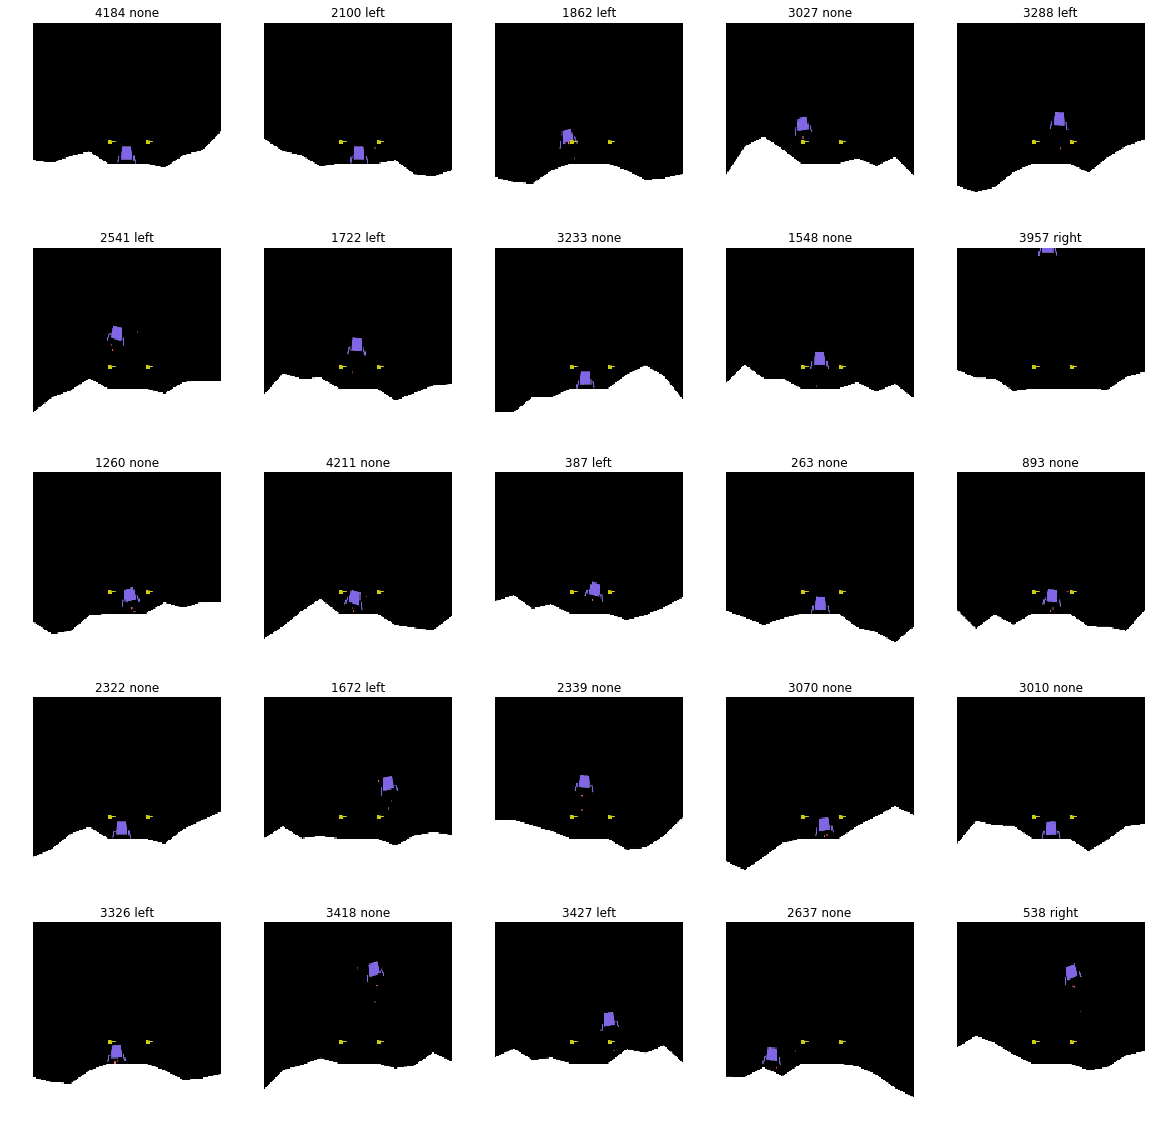

In [6]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow((X_train[i_rand]))
    plt.title((str(i_rand) + " " + y_train[i_rand]))   

In [0]:
# Convert class vectors to binary class matrices.
num_classes = 4
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num,num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

Create model

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxP

Fit the model

In [9]:
# Set up the callback to save the best model based on validation data
best_weights_filepath = './best_weights_notebook21.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

# Reload best weights
model.load_weights(best_weights_filepath)

Instructions for updating:
Use tf.cast instead.
Train on 3564 samples, validate on 892 samples
Epoch 1/100
3564/3564 [==============================] - 12s 3ms/step - loss: 0.4114 - acc: 0.8003 - val_loss: 0.3571 - val_acc: 0.8445
Epoch 2/100
3564/3564 [==============================] - 3s 945us/step - loss: 0.3292 - acc: 0.8581 - val_loss: 0.3258 - val_acc: 0.8579
Epoch 3/100
3564/3564 [==============================] - 3s 941us/step - loss: 0.3037 - acc: 0.8671 - val_loss: 0.3100 - val_acc: 0.8613
Epoch 4/100
3564/3564 [==============================] - 3s 934us/step - loss: 0.2881 - acc: 0.8749 - val_loss: 0.2998 - val_acc: 0.8672
Epoch 5/100
3564/3564 [==============================] - 3s 941us/step - loss: 0.2709 - acc: 0.8803 - val_loss: 0.2863 - val_acc: 0.8809
Epoch 6/100
3564/3564 [==============================] - 3s 934us/step - loss: 0.2483 - acc: 0.8893 - val_loss: 0.2743 - val_acc: 0.8910
Epoch 7/100
3564/3564 [==============================] - 3s 928us/step - loss: 0.236

Plot the losses

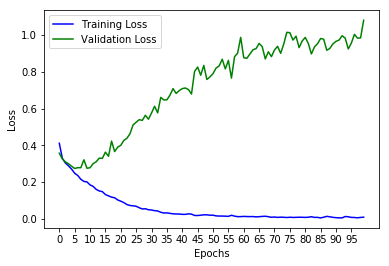

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::5])
plt.legend()
plt.show()

Make Predictions

In [11]:
# Make a set of predictions for the test data
pred = model.predict_classes(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, pred) # normalize=True, sample_weight=None
task_accuracy_comparisons["Color_Imbalance_Classes"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

Accuracy: 0.7974882260596546
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       861
           1       0.83      0.80      0.82       916
           2       0.45      0.21      0.28        68
           3       0.59      0.26      0.36        66

   micro avg       0.80      0.80      0.80      1911
   macro avg       0.66      0.54      0.57      1911
weighted avg       0.79      0.80      0.79      1911

Confusion matrix
[[757  97   3   4]
 [162 736  13   5]
 [ 25  26  14   3]
 [ 21  27   1  17]]


### Grayscale and balance class

Images used for training are converted to gray scale and classes are balanced by oversampling the classes  

In [11]:
input_shape = (img_width, img_height,1)
X_data_part = np.ndarray((count, input_shape[2], input_shape[1], input_shape[0]), dtype=np.float)

# Initialise arrays for data storage
X_data = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.str)


# Iterate through the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):

    # Load the images and resize them
    image = cv2.imread(image_file, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image,(img_height, img_width), interpolation=cv2.INTER_CUBIC)
    

    # If channel order of network does not match open cv format swap it
    if K.image_data_format() == 'channels_first':
        image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
    
    # Add image data to data array and normalise
    
    X_data_part[i] = image
    X_data_part[i] = X_data_part[i]/255

    # Add label to label array
    lb = moves[image_file[-6]]
        
    y_data = np.append(y_data, lb)

    if i%1000 == 0: print('Processed {} Images'.format(i))
        
X_data = np.rollaxis(X_data_part, 1, 4)

Processed 0 Images
Processed 1000 Images
Processed 2000 Images
Processed 3000 Images
Processed 4000 Images
Processed 5000 Images
Processed 6000 Images


Plot class distribution

{'left': 2932, 'none': 2974, 'right': 223, 'up': 238}

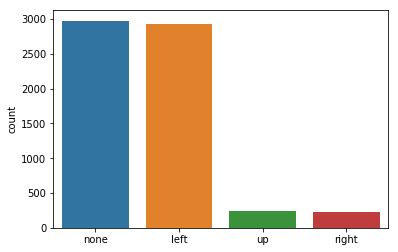

In [13]:
sns.countplot(y_data)
unique, counts = np.unique(y_data, return_counts=True)
dict(zip(unique, counts))

Over sample the classes which have less examples so all classes have equal number of samples

In [0]:
nsamples, nx, ny,c = X_data.shape

ros = RandomOverSampler(return_indices=True)

X_resampled, y_resampled,idx_resampled = ros.fit_sample(X_data.reshape(len(X_data), nx*ny*c), y_data)
X_resampled, y_resampled = shuffle(X_resampled, y_resampled)
X_resampled = X_resampled.reshape((len(X_resampled),nx,ny,c))


{'left': 2974, 'none': 2974, 'right': 2974, 'up': 2974}

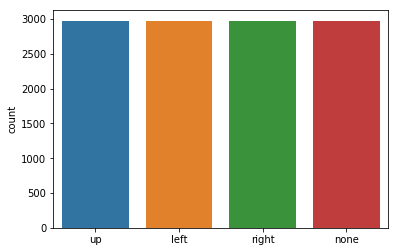

In [15]:
sns.countplot(y_resampled)
unique, counts = np.unique(y_resampled, return_counts=True)
dict(zip(unique, counts))

Plot few images 

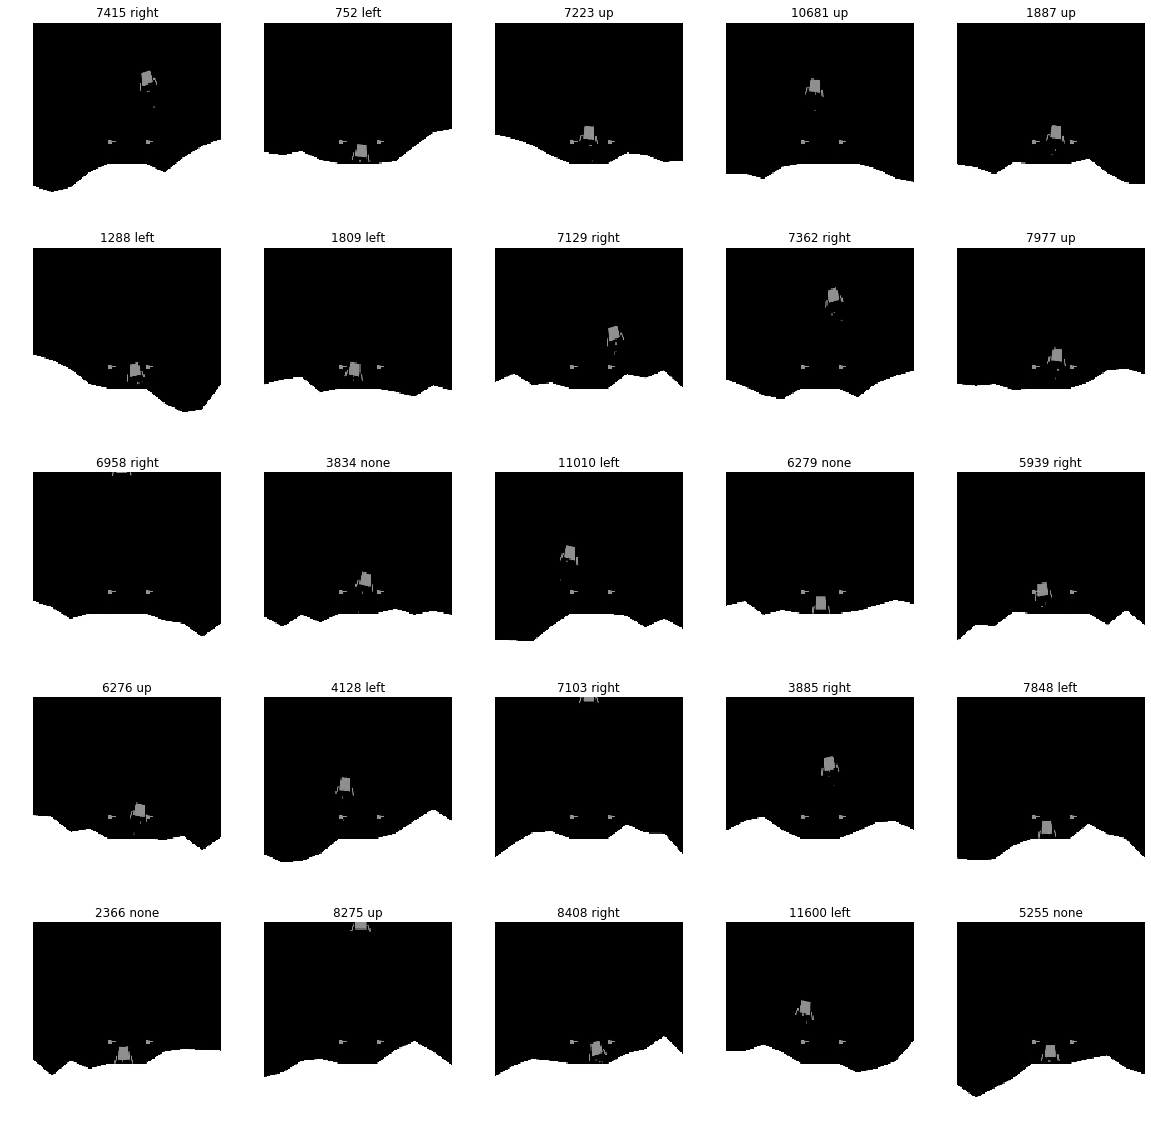

In [16]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_resampled.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow((X_resampled.reshape(len(X_resampled), 150,150)[i_rand]),cmap='gray')
    plt.title((str(i_rand) + " " + y_resampled[i_rand]))

Split data into training and testing

In [0]:
# Perform split to train, validate and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0, test_size = 0.30, train_size = 0.7)

In [0]:
# Convert class vectors to binary class matrices.
num_classes = 4
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num,num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

Create model

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
__________

Fit the model

In [16]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

# Set up the callback to save the best model based on validation data
best_weights_filepath = './best_weights_notebook21.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

model.compile(loss='categorical_crossentropy', 
              optimizer=adam(lr=1e-3), #lr: float >= 0. Learning rate.
              metrics=['accuracy'])

history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath)

Train on 6704 samples, validate on 1676 samples
Epoch 1/100
6704/6704 [==============================] - 6s 873us/step - loss: 1.1496 - acc: 0.4937 - val_loss: 0.9168 - val_acc: 0.6301
Epoch 2/100
6704/6704 [==============================] - 4s 638us/step - loss: 0.8911 - acc: 0.6220 - val_loss: 0.7839 - val_acc: 0.6724
Epoch 3/100
6704/6704 [==============================] - 4s 635us/step - loss: 0.7582 - acc: 0.6841 - val_loss: 0.6518 - val_acc: 0.7464
Epoch 4/100
6704/6704 [==============================] - 4s 639us/step - loss: 0.6433 - acc: 0.7393 - val_loss: 0.5639 - val_acc: 0.7733
Epoch 5/100
6704/6704 [==============================] - 4s 637us/step - loss: 0.5555 - acc: 0.7780 - val_loss: 0.4863 - val_acc: 0.8150
Epoch 6/100
6704/6704 [==============================] - 4s 639us/step - loss: 0.4849 - acc: 0.8067 - val_loss: 0.4578 - val_acc: 0.8246
Epoch 7/100
6704/6704 [==============================] - 4s 637us/step - loss: 0.4101 - acc: 0.8401 - val_loss: 0.3852 - val_acc: 

Calculate losses

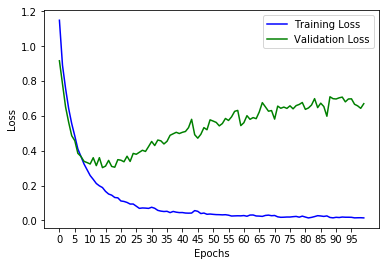

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::5])
plt.legend()
plt.show()

Make predictions

In [22]:
# Make a set of predictions for the test data
pred = model.predict_classes(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, pred) # normalize=True, sample_weight=None
task_accuracy_comparisons["Gray_balance_classes"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test_num, pred))

Accuracy: 0.8862426449985991
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       890
           1       0.81      0.76      0.79       854
           2       0.95      1.00      0.97       914
           3       0.95      1.00      0.97       911

   micro avg       0.89      0.89      0.89      3569
   macro avg       0.88      0.88      0.88      3569
weighted avg       0.88      0.89      0.88      3569

Confusion matrix
[[689 150  30  21]
 [150 649  23  32]
 [  0   0 914   0]
 [  0   0   0 911]]


### Modifying the model to get better accuracy

#### KernalSize 4 and one more hidden layer

Increase the kernal or filter size by 1 and adding one more hidden layer to model 

In [18]:
model = Sequential()
model.add(Conv2D(32, (4,4), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (4,4)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (4,4)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (4,4)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 147, 147, 32)      544       
_________________________________________________________________
activation_11 (Activation)   (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 70, 70, 32)        16416     
_________________________________________________________________
activation_12 (Activation)   (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        32832     
__________

Train the model

In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

# Set up the callback to save the best model based on validation data
best_weights_filepath = './best_weights_notebook21.hdf51'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)


history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp],
           class_weight=class_weights)

#reload best weights
model.load_weights(best_weights_filepath)

Train on 6704 samples, validate on 1676 samples
Epoch 1/100
6704/6704 [==============================] - 7s 1ms/step - loss: 0.5070 - acc: 0.7619 - val_loss: 0.4365 - val_acc: 0.7894
Epoch 2/100
6704/6704 [==============================] - 5s 732us/step - loss: 0.4365 - acc: 0.7965 - val_loss: 0.3978 - val_acc: 0.8104
Epoch 3/100
6704/6704 [==============================] - 5s 734us/step - loss: 0.3841 - acc: 0.8267 - val_loss: 0.3282 - val_acc: 0.8558
Epoch 4/100
6704/6704 [==============================] - 5s 737us/step - loss: 0.3244 - acc: 0.8576 - val_loss: 0.2796 - val_acc: 0.8760
Epoch 5/100
6704/6704 [==============================] - 5s 736us/step - loss: 0.2763 - acc: 0.8801 - val_loss: 0.2363 - val_acc: 0.9054
Epoch 6/100
6704/6704 [==============================] - 5s 747us/step - loss: 0.2389 - acc: 0.9009 - val_loss: 0.2154 - val_acc: 0.9117
Epoch 7/100
6704/6704 [==============================] - 5s 745us/step - loss: 0.2098 - acc: 0.9127 - val_loss: 0.2009 - val_acc: 0.

Plot losses

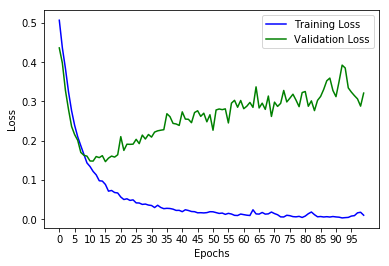

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::5])
plt.legend()
plt.show()

Make prediction

In [26]:
# Make a set of predictions for the test data
pred = model.predict_classes(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, pred) # normalize=True, sample_weight=None
task_accuracy_comparisons["Kernalsize4_and_extraHiddenLayer"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")

print(metrics.confusion_matrix(y_test_num, pred))

Accuracy: 0.891846455589801
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       890
           1       0.82      0.77      0.80       854
           2       0.93      1.00      0.97       914
           3       0.95      1.00      0.97       911

   micro avg       0.89      0.89      0.89      3569
   macro avg       0.89      0.89      0.89      3569
weighted avg       0.89      0.89      0.89      3569

Confusion matrix
[[700 140  26  24]
 [130 658  39  27]
 [  0   0 914   0]
 [  0   0   0 911]]


Kernal size 3 and a extra hidden layer

In [21]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
activation_17 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_18 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 64)        18496     
__________

Fit the model

In [22]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

# Set up the callback to save the best model based on validation data
best_weights_filepath = './best_weights_notebook21.hdf51'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)


history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp],
           class_weight=class_weights)

#reload best weights
model.load_weights(best_weights_filepath)

Train on 6704 samples, validate on 1676 samples
Epoch 1/100
6704/6704 [==============================] - 5s 739us/step - loss: 0.5056 - acc: 0.7622 - val_loss: 0.4365 - val_acc: 0.7988
Epoch 2/100
6704/6704 [==============================] - 4s 626us/step - loss: 0.4311 - acc: 0.8009 - val_loss: 0.3839 - val_acc: 0.8298
Epoch 3/100
6704/6704 [==============================] - 4s 627us/step - loss: 0.3704 - acc: 0.8335 - val_loss: 0.3338 - val_acc: 0.8514
Epoch 4/100
6704/6704 [==============================] - 4s 629us/step - loss: 0.3286 - acc: 0.8543 - val_loss: 0.2887 - val_acc: 0.8766
Epoch 5/100
6704/6704 [==============================] - 4s 642us/step - loss: 0.2862 - acc: 0.8761 - val_loss: 0.2411 - val_acc: 0.9081
Epoch 6/100
6704/6704 [==============================] - 4s 638us/step - loss: 0.2425 - acc: 0.8978 - val_loss: 0.2217 - val_acc: 0.9115
Epoch 7/100
6704/6704 [==============================] - 4s 632us/step - loss: 0.2138 - acc: 0.9142 - val_loss: 0.2010 - val_acc: 

Plot losses

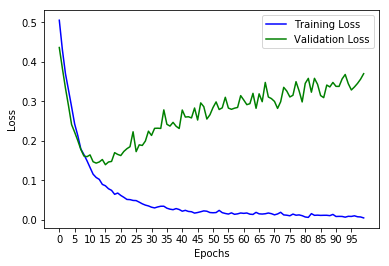

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::5])
plt.legend()
plt.show()

Make prediction

In [30]:
# Make a set of predictions for the test data
pred = model.predict_classes(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, pred) # normalize=True, sample_weight=None
task_accuracy_comparisons["Kernalsize3_and_extraHiddenLayer"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")

print(metrics.confusion_matrix(y_test_num, pred))

Accuracy: 0.9010927430652844
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       890
           1       0.86      0.77      0.81       854
           2       0.94      1.00      0.97       914
           3       0.96      1.00      0.98       911

   micro avg       0.90      0.90      0.90      3569
   macro avg       0.90      0.90      0.90      3569
weighted avg       0.90      0.90      0.90      3569

Confusion matrix
[[733 111  32  14]
 [143 658  26  27]
 [  0   0 914   0]
 [  0   0   0 911]]


##### Save the model

In [0]:
model.save("model_without_frames.h5")

### Multiple sequential frames

4 Frames are used for this task

In [0]:
# dataset
train_data_dir = 'LunarLanderFramesPart1/'


# desired dimensions of our images.
img_width, img_height = 150, 150

# different backends (e.g. tensorflow and theano) use different orderings for image data - fix this!
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    

image_filenames = [train_data_dir+i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset

In [7]:
input_shape = (img_width, img_height,4)
X_data_part = np.ndarray((4, 1, input_shape[1], input_shape[0]), dtype=np.float)
y_data_part= np.ndarray(0, dtype=np.str)

# Initialise arrays for data storage
X_data = np.ndarray((round(10000/4), input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.str)

j=0
k=0
# Iterate through the filenames and for each one load the image, resize and normalise and create a 4 framed image
for i, image_file in enumerate(image_filenames):

    # Load the images and resize them
    image = cv2.imread(image_file, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image,(img_height, img_width), interpolation=cv2.INTER_CUBIC)
    

    # If channel order of network does not match open cv format swap it
    if K.image_data_format() == 'channels_first':
        image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
    
    # Add image data to temp data array and normalise
    X_data_part[j] = image    
    X_data_part[j] = X_data_part[j]/255
    j+=1
    # Add label to temp label array
    lb = moves[image_file[-6]]
        
    y_data_part = np.append(y_data_part, lb)
    
    # After 4 images are read they are reshaped and stored in data array
    if(j == 4):
        X_data[k] = X_data_part.reshape(150,150,4)
        k+=1
        y_data = np.append(y_data, y_data_part[0])
        X_data_part = np.ndarray((4, 1, input_shape[1], input_shape[0]), dtype=np.float)
        y_data_part= np.ndarray(0, dtype=np.str)
        j=0


    if i%1000 == 0: print('Processed {} Images'.format(i))
    # just to limit the data to 10k images
    if i == 10000:break;
        


Processed 0 Images
Processed 1000 Images
Processed 2000 Images
Processed 3000 Images
Processed 4000 Images
Processed 5000 Images
Processed 6000 Images
Processed 7000 Images
Processed 8000 Images
Processed 9000 Images
Processed 10000 Images


Plot the distribution of the class

{'left': 1140, 'none': 1181, 'right': 89, 'up': 90}

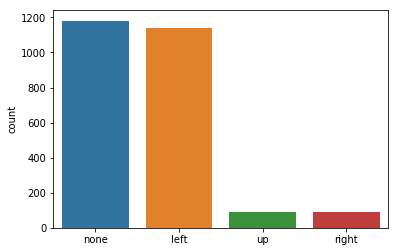

In [8]:
sns.countplot(y_data)
unique, counts = np.unique(y_data, return_counts=True)
dict(zip(unique, counts))

Balance the classes

In [0]:
nsamples, nx, ny,c = X_data.shape

ros = RandomOverSampler(return_indices=True)

X_resampled, y_resampled,idx_resampled = ros.fit_sample(X_data.reshape(len(X_data), nx*ny*c), y_data)
X_resampled, y_resampled = shuffle(X_resampled, y_resampled)
X_resampled = X_resampled.reshape((len(X_resampled),nx,ny,c))


{'left': 1181, 'none': 1181, 'right': 1181, 'up': 1181}

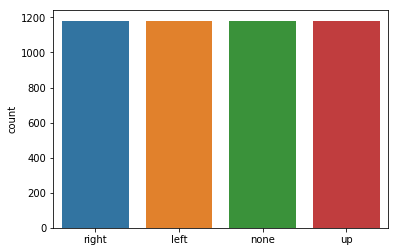

In [10]:
sns.countplot(y_resampled)
unique, counts = np.unique(y_resampled, return_counts=True)
dict(zip(unique, counts))

Split data

In [0]:
# Perfrom split to train, validation, test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0, test_size = 0.30, train_size = 0.7)

In [0]:
# Convert class vectors to binary class matrices.
num_classes = 4
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num,num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

Create model

In [13]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      1184      
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxP

Fit the model

In [14]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

# Set up the callback to save the best model based on validation data
best_weights_filepath = './best_weights_notebook21.hdf51'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)


history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp],
           class_weight=class_weights)

#reload best weights
model.load_weights(best_weights_filepath)

Instructions for updating:
Use tf.cast instead.
Train on 2644 samples, validate on 662 samples
Epoch 1/100
2644/2644 [==============================] - 11s 4ms/step - loss: 0.5677 - acc: 0.7501 - val_loss: 0.5624 - val_acc: 0.7500
Epoch 2/100
2644/2644 [==============================] - 3s 1ms/step - loss: 0.5624 - acc: 0.7500 - val_loss: 0.5622 - val_acc: 0.7500
Epoch 3/100
2644/2644 [==============================] - 3s 1ms/step - loss: 0.5616 - acc: 0.7500 - val_loss: 0.5605 - val_acc: 0.7500
Epoch 4/100
2644/2644 [==============================] - 3s 1ms/step - loss: 0.5581 - acc: 0.7500 - val_loss: 0.5556 - val_acc: 0.7500
Epoch 5/100
2644/2644 [==============================] - 3s 1ms/step - loss: 0.5384 - acc: 0.7536 - val_loss: 0.5111 - val_acc: 0.7640
Epoch 6/100
2644/2644 [==============================] - 3s 1ms/step - loss: 0.4733 - acc: 0.7805 - val_loss: 0.4454 - val_acc: 0.7885
Epoch 7/100
2644/2644 [==============================] - 3s 1ms/step - loss: 0.4103 - acc: 0.8

Plot the losses

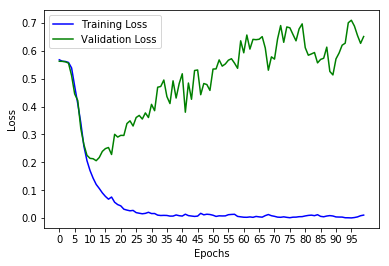

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::5])
plt.legend()
plt.show()

Make prediction and calculate accuracy

In [18]:
# Make a set of predictions for the test data
pred = model.predict_classes(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, pred) # normalize=True, sample_weight=None
task_accuracy_comparisons["4 Framed Images"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")

print(metrics.confusion_matrix(y_test_num, pred))

Accuracy: 0.8561354019746121
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       358
           1       0.72      0.75      0.74       347
           2       0.96      0.99      0.97       348
           3       0.96      1.00      0.98       365

   micro avg       0.86      0.86      0.86      1418
   macro avg       0.85      0.86      0.85      1418
weighted avg       0.85      0.86      0.85      1418

Confusion matrix
[[245  96   7  10]
 [ 73 261   7   6]
 [  0   5 343   0]
 [  0   0   0 365]]


Save the model

In [0]:
model.save("model_with_frames.h5")

### Comparision of tasks

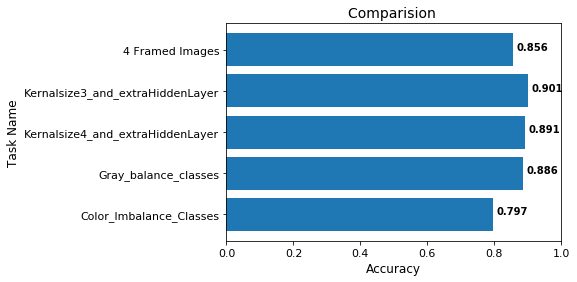

In [26]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(task_accuracy_comparisons)), list(task_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(task_accuracy_comparisons)), list(task_accuracy_comparisons.keys()))
_ = plt.title("Comparision ",fontsize=14)
_ = plt.xlabel('Accuracy',fontsize=12)
_ = plt.ylabel('Task Name',fontsize=12)
_ = plt.tick_params(axis='both', which='major', labelsize=11)
#displaying labels for each bar
for i, v in enumerate(list(task_accuracy_comparisons.values())):
    a=round(v,4)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()


# Conclusion

It can be observed that reinforcement learning approach was much better, efficient, simple and fast compared to image based learning. Image based learning is computationally expensive. It takes long time for the model to train. 
In image based learning the screenshots of the game played by an expert was given to the model to classify i.e looking at a particular screenshot which mode the spaceship should take(More of making a classification mode for images). I tried different approaches and got a best model with images turned gray scale and all classes have equal number of samples with kernel size of 3 in a layer of CNN and 4 hidden layers. 
I got an accuracy of **90%**. But when it was deployed in real word i.e model is told to play the actual game it performed very badly and got **negative** reward after 200 episodes of game. The spaceship was not even flying it was simply falling. The reasons might be that the model is not trained on the images which it gets in actual game and it is not trained on the initial position of the spaceship due to which it makes wrong prediction and the spaceship tilts by an angle. 
Furthermore, there are no images at angle on which model is trained and hence it performs very poorly. Spaceship was just **crashing**. Initially I tried with single frame trained model and then tried with multiple sequential frames in either cases the model performed poorly. Reasons are simple there were insufficient images or there were not all the images from real world to make the model play the game nicely and smoothly. For Single frame average reward was **-451.00** and for 4 sequential frames average reward was **-177.23**. Sequential frames model had better performance compaired to single frame model.
On the other hand reinforcement learning approach gave very good results and got **positive** reward with an average total reward of **178.84** after 200 episodes. In this approach the agent was sent in the real word and was learning on its own by receiving rewards for each action. This approach was fast and computationally inexpensive. After training for 50 thousand number of steps the agent played very well in the real world.    